In [1]:
!pip install transformers datasets tweet-preprocessor

     |████████████████████████████████| 1.4MB 8.2MB/s 
     |████████████████████████████████| 163kB 28.5MB/s 
     |████████████████████████████████| 890kB 23.5MB/s 
     |████████████████████████████████| 2.9MB 41.1MB/s 
     |████████████████████████████████| 245kB 55.4MB/s 
     |████████████████████████████████| 17.7MB 206kB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b69a1a8d11152a61e5c69d12f258da89895932b5745a9a465148c60a02f02e0d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import preprocessor as p # tweet-preprocessor
import nltk
import re
import seaborn as sns
import torch

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from datasets import Dataset
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm

In [3]:
dataset_dem = pd.read_csv('/content/drive/MyDrive/democrat_tweets_v2.csv')
dataset_gop = pd.read_csv('/content/drive/MyDrive/republican_tweets_v2.csv')

dataset_dem["label"] = "Democrat"
dataset_gop["label"] = "Republican"

dataset_final = pd.concat([dataset_dem, dataset_gop])
dataset_final.reset_index(drop=True, inplace=True)

### Build dataset for classification

In [4]:
LABEL_MAP = {
    "Democrat": 0,
    "Republican": 1
}

def buildLabels(row):
    return LABEL_MAP.get(row["label"])

def cleanTweet(row):
  tweet = row["text"]
  tweet = str(p.clean(tweet))
  tweet = re.sub(r'[^\w\s]', '', tweet) # punctuation
  tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet) # numbers
  return tweet

  
dataset_final["label"] = dataset_final.apply(lambda row: buildLabels(row), axis=1)
dataset_final["clean_text"] = dataset_final.apply(lambda row: cleanTweet(row), 
                                                  axis=1)

In [5]:
dataset_clf = dataset_final[["clean_text", "label"]]
dataset_clf.reset_index(drop=True, inplace=True)

In [ ]:
dataset_clf.to_csv('/content/drive/MyDrive/labeled_dataset_v2.csv')

In [6]:
X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                  dataset_clf.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset_clf.label.values)

dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

dataset_clf.loc[X_train, 'data_type'] = 'train'
dataset_clf.loc[X_val, 'data_type'] = 'test'
dataset_clf.groupby(['label', 'data_type']).count()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


clean_text
label data_type            
0     test              187
      train            1058
1     test              168
      train             953

### Try out BERTForSequenceClassification to see how it goes

Can be our baseline as this just uses a single torch Linear layer for classification (i.e. assumes data is linearly seperable) after a Dropout on top of the BERT model

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(0.0, 128.0)

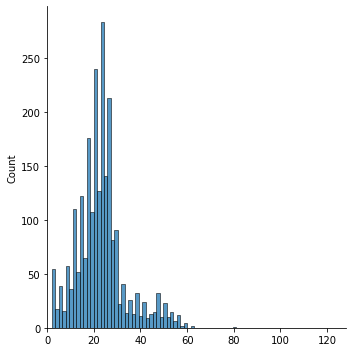

In [8]:
# find distribution of length of tokenized tweets
lens = []

for tweet in dataset_final.clean_text:
  tokens = tokenizer.encode(tweet, max_length=512)
  lens.append(len(tokens))

sns.displot(lens)
plt.xlim([0, 128])

In [9]:
# tokenize train and test data so BERT can understand it
encoded_data_train = tokenizer.batch_encode_plus(
    dataset_clf[dataset_clf.data_type=='train'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True,
    truncation=True,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    dataset_clf[dataset_clf.data_type=='test'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    truncation=True,
    return_tensors='pt'
)


# destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset_clf[dataset_clf.data_type=='train'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(dataset_clf[dataset_clf.data_type=='test'].label.values)

In [10]:
tokenizer.convert_ids_to_tokens(input_ids_test[0])

['[CLS]',
 'trump',
 'went',
 'to',
 'a',
 'movie',
 'as',
 'his',
 'brother',
 'died',
 'alone',
 'in',
 'the',
 'hospital',
 'his',
 'niece',
 'mary',
 'trump',
 'writes',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [11]:
train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

BATCH_SIZE = 8

train_dataloader = DataLoader(train_data, 
                              sampler=RandomSampler(train_data), 
                              batch_size=BATCH_SIZE)

test_dataloader = DataLoader(test_data,
                             sampler=SequentialSampler(test_data),
                             batch_size=BATCH_SIZE)

In [41]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [43]:
EPOCHS = 5

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_dataloader)*EPOCHS)

In [14]:
def auc_score(preds, labels):
  soft_preds = softmax(preds, axis=1) # logit -> probability
  print(preds.shape, labels.shape)
  if np.shape(preds)[1] > 2: # check for multi-class
    return roc_auc_score(labels, soft_preds, multi_class='ovr')
  else:
    soft_preds = soft_preds[:,1]
    return roc_auc_score(labels, soft_preds)

def acc_score_by_class(preds, labels):
  label_dict_inverse = {v: k for k, v in LABEL_MAP.items()} 

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

following is mostly taken from [this medium article](https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613)

In [15]:
def evaluate(model, dataloader):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []
  
  for batch in dataloader:
      
      # convert data to CUDA
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {
          'input_ids':      batch[0],
          'attention_mask': batch[1],
          'labels':         batch[2],
      }

      with torch.no_grad():        
          outputs = model(**inputs) # get predictions
          
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
  
  loss_val_avg = loss_val_total/len(dataloader) 
  
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
          
  return loss_val_avg, predictions, true_vals

In [46]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
print(device)
torch.cuda.get_device_name(0)

cuda


'Tesla T4'

In [44]:
def train(model, epochs, train_dataloader, test_dataloader, optimizer, scheduler):
  losses_train = []
  losses_test = []
  aucs_test = []

  for epoch in tqdm(range(1, epochs+1)): # use tqdm for a progress bar
    model.train() # enter training mode
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        
        # get CUDA data
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }

        outputs = model(**inputs) # evaluate
        
        # for reference, we are using cross-entropy loss here,
        # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # do backprop

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    losses_train.append(loss_train_avg)
    
    val_loss, predictions, true_vals = evaluate(model, test_dataloader)
    auc = auc_score(predictions, true_vals)
    losses_test.append(val_loss)
    aucs_test.append(auc)
    tqdm.write(f'Testing loss: {val_loss}')
    tqdm.write(f'AUC: {auc}')
    
  return losses_train, losses_test, aucs_test

In [47]:
losses_train, losses_test, aucs_test = train(model, 
                                             EPOCHS, 
                                             train_dataloader, 
                                             test_dataloader, 
                                             optimizer, 
                                             scheduler)


Epoch 1
Training loss: 0.633859322184608
(355, 2) (355,)
Testing loss: 0.5829252706633674
AUC: 0.7649286987522281



Epoch 2
Training loss: 0.4988330973992272
(355, 2) (355,)
Testing loss: 0.5560996558931138
AUC: 0.8045263559969442



Epoch 3
Training loss: 0.3551964211085486
(355, 2) (355,)
Testing loss: 0.6006711941626337
AUC: 0.8007066462948815



Epoch 4
Training loss: 0.25539226988182656
(355, 2) (355,)
Testing loss: 0.6508711763554149
AUC: 0.807231983702572



Epoch 5
Training loss: 0.196431744030662
(355, 2) (355,)
Testing loss: 0.6909815950526131
AUC: 0.8019798828622359



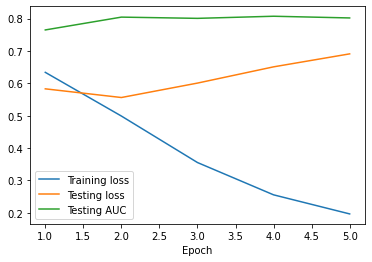

In [50]:
x = np.arange(1, 6)
plt.plot(x, losses_train, label='Training loss')
plt.plot(x, losses_test, label='Testing loss')
plt.plot(x, aucs_test, label='Testing AUC')

plt.xlabel('Epoch')
plt.legend()

Accuracy: 0.7492957746478873


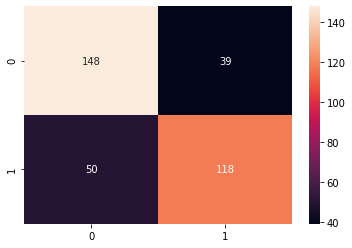

In [51]:
_, preds, true_vals = evaluate(model, test_dataloader)
print(f"Accuracy: {accuracy_score(true_vals, np.argmax(preds, axis=1))}")
sns.heatmap(confusion_matrix(true_vals, np.argmax(preds, axis=1)), annot=True, fmt="d")